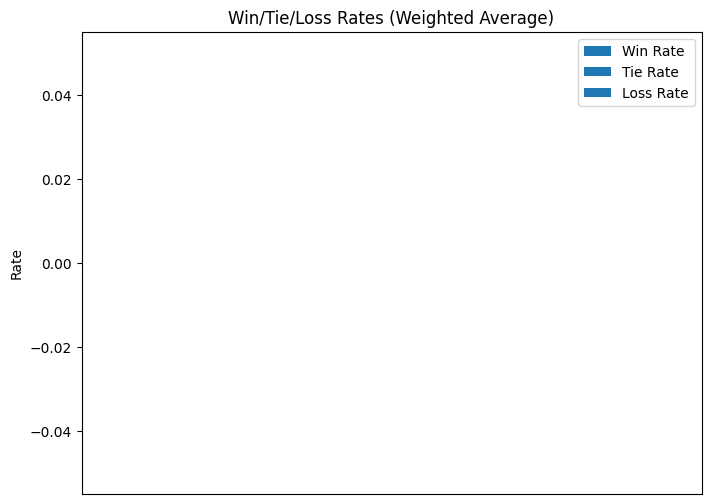

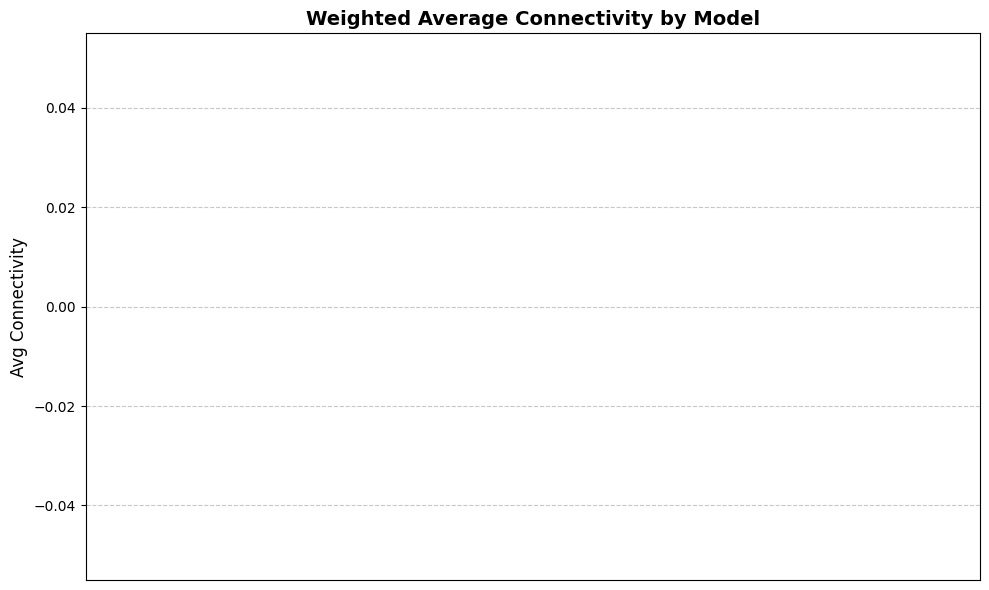

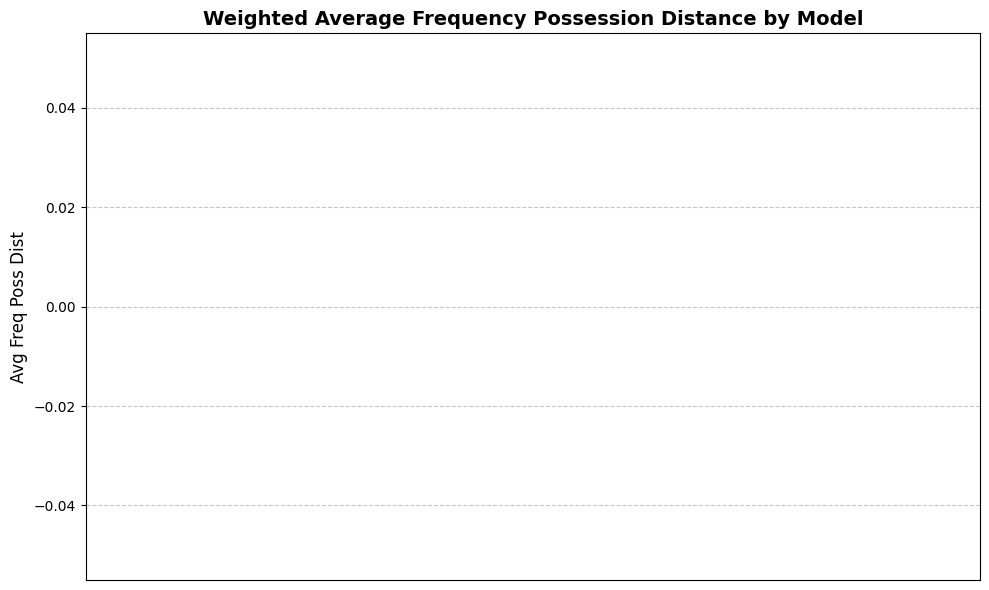

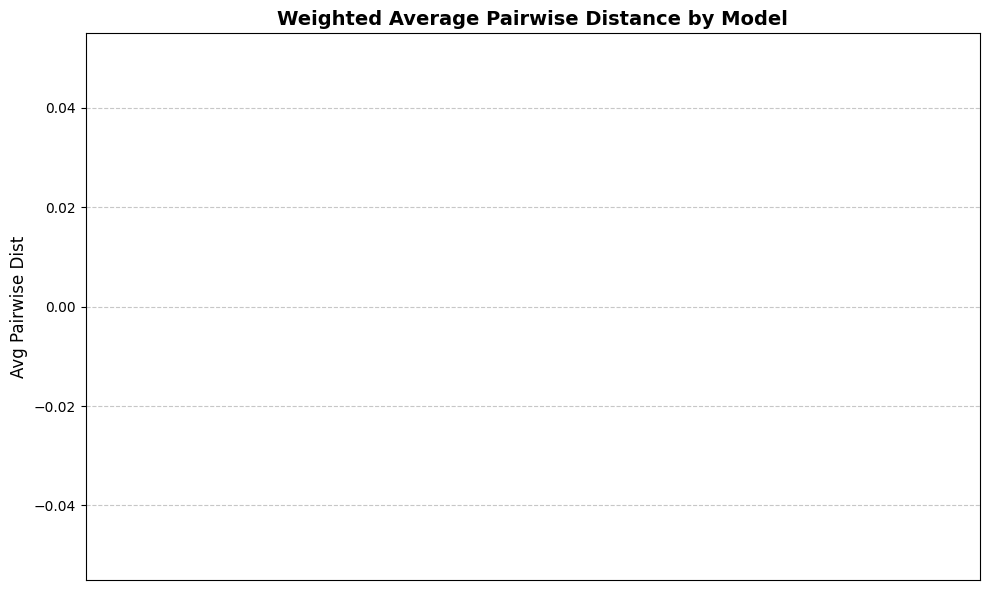

ValueError: min() arg is an empty sequence

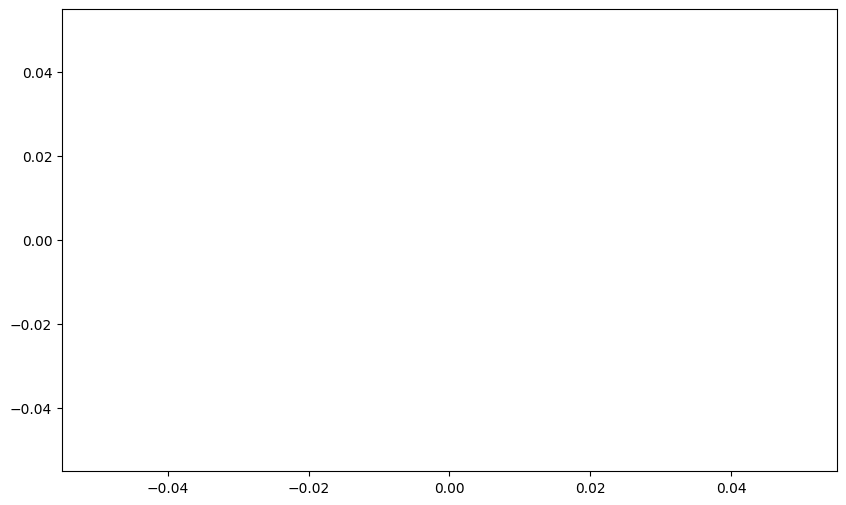

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

# --- Raw text data (note that the first block now corresponds to PPO) ---
data = r'''
Individual statistics for HUGO:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
     0        4     1           0            0                   0.87676               0.01814              402.241       94.7687          18.25    1080.69
     1        8     1           0            0                   0.8484                0.02201              384.496       84.1916          16       1099.29
     2        7     0.71429     0.14286      0.14286             0.80006               0.02983              372.788       62.4196          11.1429  1044.49
     3        1     0           1            0                   0.67182               0.0583               361.24        11.4286           0       1038.39
     4        4     0.75        0.25         0                   0.71084               0.04313              352.22        19.5572           1.75    1094.79

Individual statistics for PPO:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
     5        4     0.5         0.5          0                   0.33918               0.02543              460.055       40.6607          6.5      1043.85
     6        7     0.57143     0.14286      0.28571             0.26739               0.02898              423.671       24.6077          3.14286  1005.53
     7        4     0.75        0.25         0                   0.41533               0.01874              460.936       71.3736         13.25     1023.8
     8        4     1           0            0                   0.33973               0.02335              524.467       67.8462         12.25     1044.06
     9        8     0.875       0.125        0                   0.3663                0.02142              489.736       70.5553         13        1042.8

Individual statistics for MAAC:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
    10        2     0              0         1                   0.21515               0.07287              76.5795      -45.5151        -10.5      972.307
    11        4     0              0.25      0.75                0.24866               0.04521              91.2216      -13.9187         -3.75     932.13
    12        6     0.16667        0         0.83333             0.20633               0.06107              82.8558      -26.9576         -6.5      963.33
    13        6     0              0         1                   0.20229               0.05523              76.7294      -20.2668         -5        879.88
    14        7     0              0         1                   0.20727               0.07079              82.2518      -39.6068         -9.28571  918.167

Individual statistics for Random:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
    15        4           0     0            1                   0.64119               0.01368              186.897      -69.3079        -16.75     878.377
    16        6           0     0            1                   0.63732               0.01289              187.92       -96.0721        -22.6667   851.848
    17        2           0     0            1                   0.64902               0.00744              189.045      -68.0385        -16.5      900.065
    18        6           0     0.5          0.5                 0.6934                0.01239              188.012      -28.5307         -7.83333  917.711
    19        6           0     0.16667      0.83333             0.68471               0.01229              181.226      -35.0283         -9.16667  893.823

Aggregated statistics per model group:
Model      Total Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff    Avg ELO
-------  -------------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  ---------
HUGO                24     0.83333     0.125        0.04167             0.80874               0.02868             377.69         65.8001         11.9167    1071.53
PPO                 27     0.74074     0.18519      0.07407             0.33997               0.02386             469.089        53.934           9.40741   1032.01
MAAC                25     0.04        0.04         0.92                0.2131                0.0608               82.0528      -28.292          -6.8        933.163
Random              24     0           0.16667      0.83333             0.66481               0.01229             186.193       -57.129         -14.0833     888.365

Matchup Win Rate Matrix (rows: team1, columns: team2):
          HUGO      PPO    MAAC    Random
------  ------  -------  ------  --------
HUGO         0  0.83333       1         1
PPO          0  0.25          1         1
MAAC         0  0             0         1
Random       0  0             0         0

Matchup Average Goal Differential Matrix (rows: team1, columns: team2):
          HUGO        PPO      MAAC    Random
------  ------  ---------  --------  --------
HUGO     -1       1.83333  11.4       22.1
PPO      -0.75    0.25      3.75      20.5454
MAAC    -11      -5.63636  -0.66667    4
Random  -17     -21.25     -2.5        0
'''

# --- Step 1. Split the text into model blocks.
blocks = []
current_model = None
current_lines = []
model_header_pattern = re.compile(r"Statistics for (.+):")

for line in data.splitlines():
    line = line.rstrip()
    if not line:
        continue  # skip blank lines
    header_match = model_header_pattern.match(line.strip())
    if header_match:
        if current_lines and current_model:
            blocks.append((current_model, current_lines))
        current_model = header_match.group(1).strip()
        current_lines = []
    else:
        current_lines.append(line)
# Add last block if any
if current_lines and current_model:
    blocks.append((current_model, current_lines))

# --- Step 2. Parse each block into rows.
# We'll parse the header row, skip the dashed separator, then get the data rows.
results = {}  # store weighted averages and Elo distributions
for model, lines_block in blocks:
    # First line is the header, split by two or more whitespace
    header_line = lines_block[0]
    columns = re.split(r'\s{2,}', header_line.strip())
    
    # Skip the dashed line (second line), and then take the rest as data rows
    data_lines = lines_block[2:]
    
    rows = []
    for row_line in data_lines:
        tokens = re.split(r'\s{2,}', row_line.strip())
        if len(tokens) == len(columns):
            row = {}
            for col, token in zip(columns, tokens):
                try:
                    if col in ["Copy", "Games"]:
                        row[col] = int(token)
                    else:
                        row[col] = float(token)
                except ValueError:
                    row[col] = token
            rows.append(row)
    
    # Compute weighted averages using 'Games' as weight
    total_games = sum(row["Games"] for row in rows)
    weighted_avg = {}
    for col in columns:
        if col in ["Copy", "Games"]:
            continue
        weighted_sum = sum(row[col] * row["Games"] for row in rows)
        weighted_avg[col] = weighted_sum / total_games if total_games > 0 else None
    
    # Collect Elo values (for boxplot later)
    elo_values = [row["ELO"] for row in rows]
    
    results[model] = {
        "total_games": total_games,
        "weighted_avg": weighted_avg,
        "elo_values": elo_values
    }

# --- Prepare data for plots ---
# Model names and sorted order (we use the order in which they appear)
models = list(results.keys())

# For stacked bar plot: extract win, tie, loss weighted averages per model.
win_rates = [results[m]["weighted_avg"]["Win Rate"] for m in models]
tie_rates = [results[m]["weighted_avg"]["Tie Rate"] for m in models]
loss_rates = [results[m]["weighted_avg"]["Loss Rate"] for m in models]

# For grouped bar plot: extract connectivity, possession distance and pairwise distance.
connectivity = [results[m]["weighted_avg"]["Avg Connectivity"] for m in models]
poss_dist = [results[m]["weighted_avg"]["Avg Freq Poss Dist"] for m in models]
pairwise = [results[m]["weighted_avg"]["Avg Pairwise Dist"] for m in models]

# For Elo box plot, collect list of Elo values per model in the same order.
elo_data = [results[m]["elo_values"] for m in models]
elo_averages = [np.mean(elo) for elo in elo_data]

# --- Plot 1: Stacked Bar Plot for Win/Tie/Loss Rates ---
x = np.arange(len(models))
bar_width = 0.5

fig1, ax1 = plt.subplots(figsize=(8, 6))
p1 = ax1.bar(x, win_rates, bar_width, label='Win Rate', color='tab:green')
p2 = ax1.bar(x, tie_rates, bar_width, bottom=win_rates, label='Tie Rate', color='tab:orange')
bottom_loss = np.array(win_rates) + np.array(tie_rates)
p3 = ax1.bar(x, loss_rates, bar_width, bottom=bottom_loss, label='Loss Rate', color='tab:red')

ax1.set_ylabel('Rate')
ax1.set_title('Win/Tie/Loss Rates (Weighted Average)')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' is a dictionary where keys are model names and each value has a "weighted_avg" dict.
models = list(results.keys())

# Extract weighted averages for each metric.
connectivity = [results[m]["weighted_avg"]["Avg Connectivity"] for m in models]
poss_dist = [results[m]["weighted_avg"]["Avg Freq Poss Dist"] for m in models]
pairwise = [results[m]["weighted_avg"]["Avg Pairwise Dist"] for m in models]

# Create a consistent color scheme for all plots
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

x = np.arange(len(models))
bar_width = 0.6  # Consistent with plot 3

# --- Plot 1: Bar Plot for Avg Connectivity ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
bars1 = ax1.bar(x, connectivity, width=bar_width, color=colors)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

ax1.set_ylabel('Avg Connectivity', fontsize=12)
ax1.set_title('Weighted Average Connectivity by Model', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=30, ha='right', fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2: Bar Plot for Avg Freq Poss Dist (Possession Distance) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
bars2 = ax2.bar(x, poss_dist, width=bar_width, color=colors)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

ax2.set_ylabel('Avg Freq Poss Dist', fontsize=12)
ax2.set_title('Weighted Average Frequency Possession Distance by Model', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=30, ha='right', fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 3: Bar Plot for Avg Pairwise Dist ---
fig3, ax3 = plt.subplots(figsize=(10, 6))
bars3 = ax3.bar(x, pairwise, width=bar_width, color=colors)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax3.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

ax3.set_ylabel('Avg Pairwise Dist', fontsize=12)
ax3.set_title('Weighted Average Pairwise Distance by Model', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=30, ha='right', fontsize=11)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 4: Bar plot of ELO averages (assuming you have elo_averages list) ---
fig4, ax4 = plt.subplots(figsize=(10, 6))
bars4 = ax4.bar(x, elo_averages, width=bar_width, color=colors)

# Add value labels
for bar in bars4:
    height = bar.get_height()
    ax4.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

# Set y-axis to start from a value slightly below the minimum
y_min = max(900, min(elo_averages) - 20)  # Start at 900 or lower if needed
y_max = max(elo_averages) + 20
ax4.set_ylim(y_min, y_max)

# Add a horizontal line showing the baseline ELO value (typically 1000)
ax4.axhline(y=1000, color='red', linestyle='--', alpha=0.7, label='Baseline ELO (1000)')

ax4.set_ylabel('ELO Rating', fontsize=12)
ax4.set_title('ELO Ratings by Model', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=30, ha='right', fontsize=11)
ax4.grid(axis='y', linestyle='--', alpha=0.7)
ax4.legend()
plt.tight_layout()
plt.show()




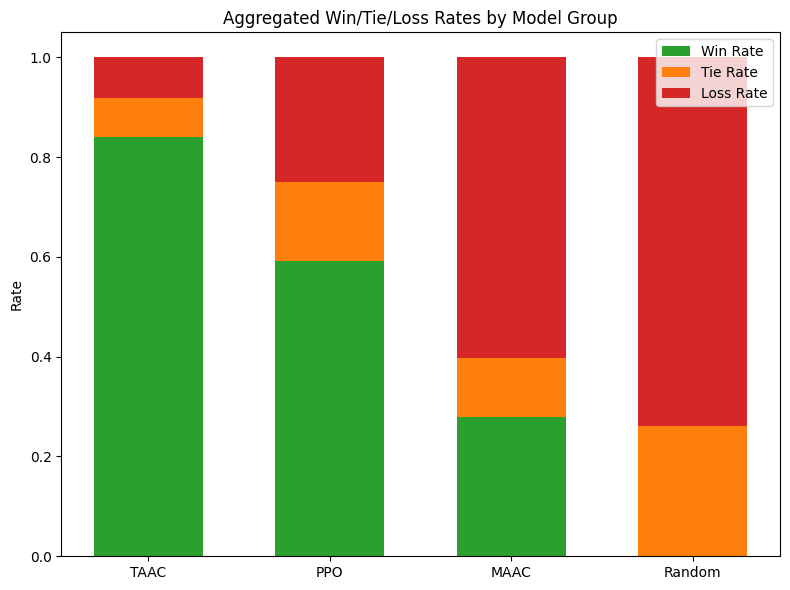

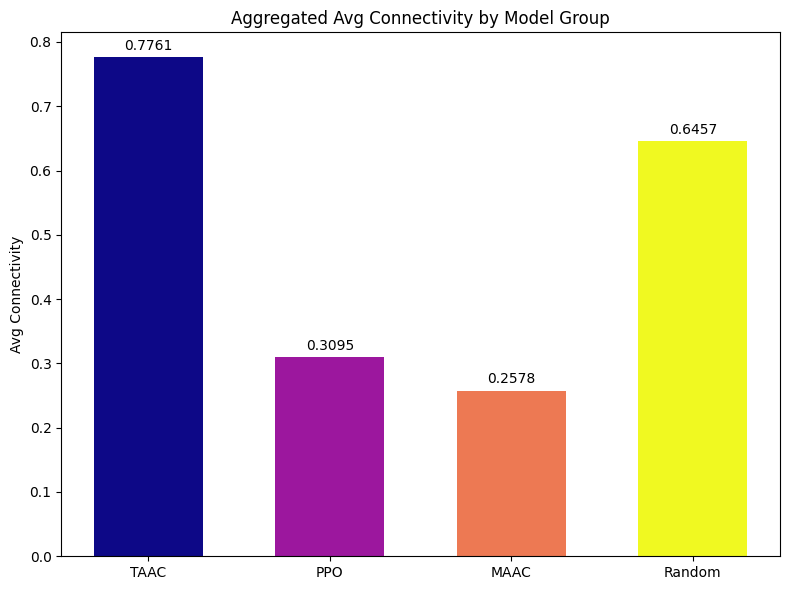

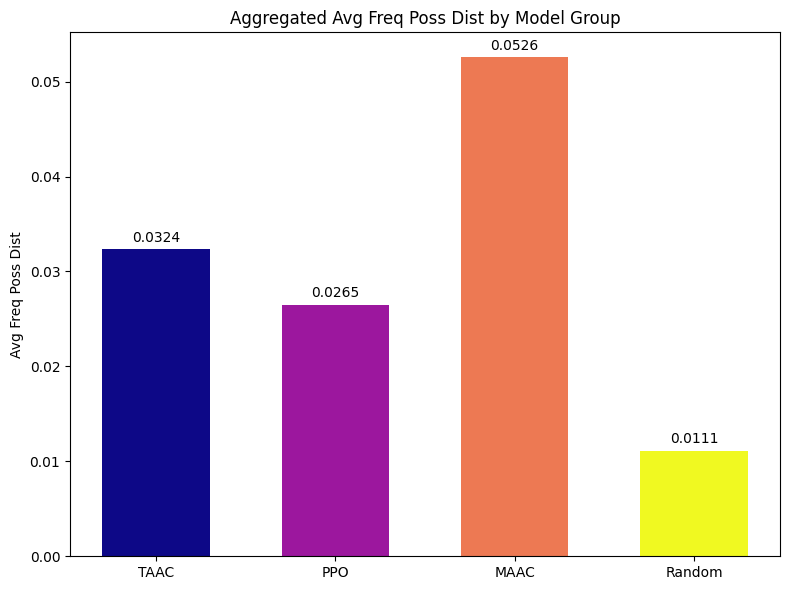

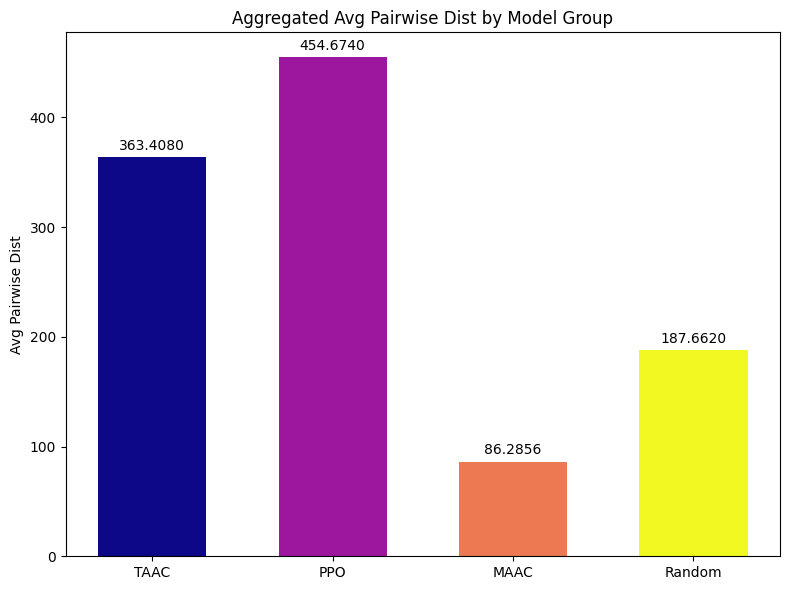

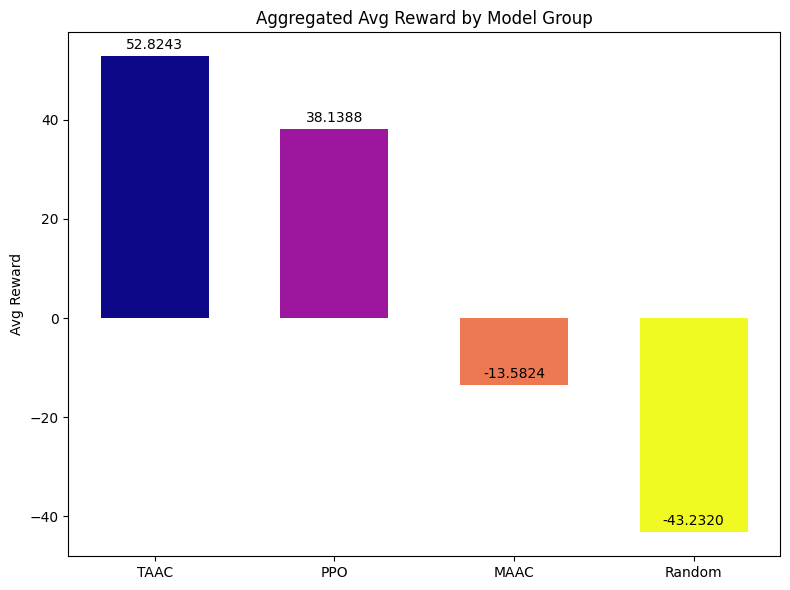

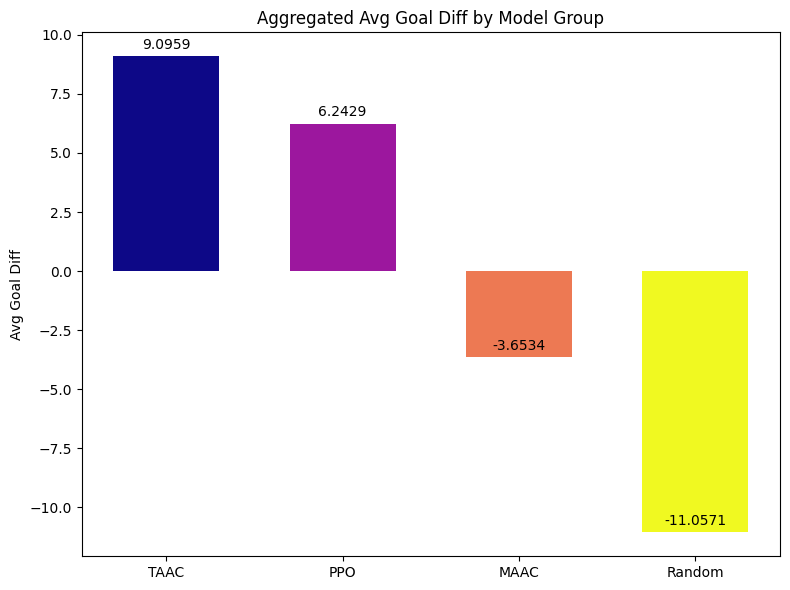

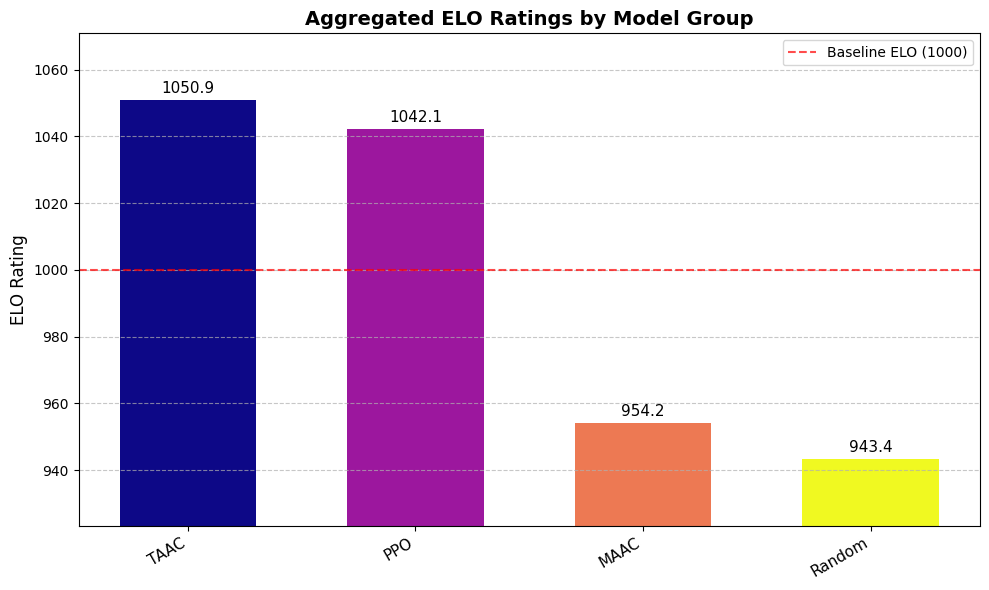

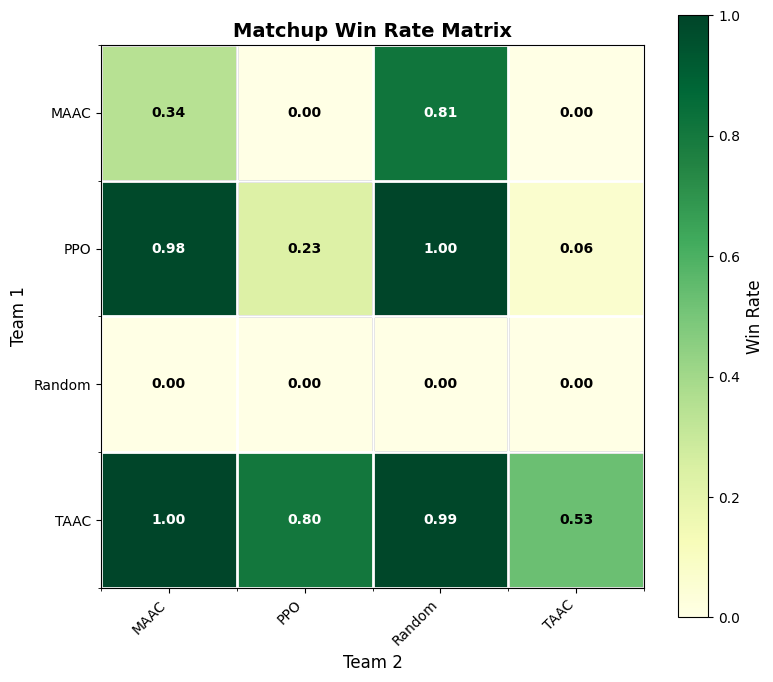

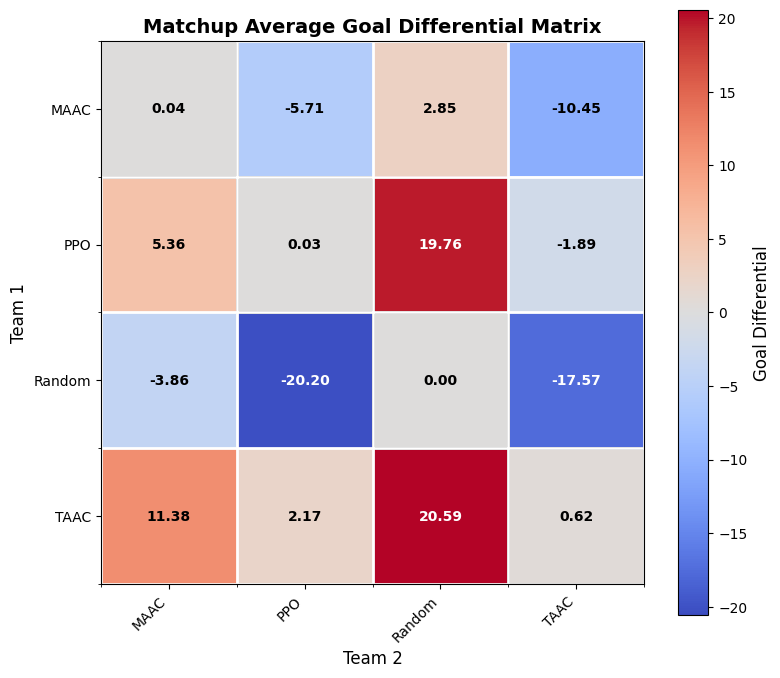

In [5]:
import re
import numpy as np
import matplotlib.pyplot as plt

# ================================
# New output (example run) as a multi-line string.
data = r'''
Individual statistics for TAAC:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
     0      256     0.84375     0.08594      0.07031             0.77954               0.03264              362.767       54.1603          9.36328  1050.99
     1      259     0.82625     0.07722      0.09653             0.7676                0.03303              362.036       50.596           8.63707  1050.71
     2      245     0.87755     0.05306      0.06939             0.78501               0.03112              366.365       56.6018          9.90612  1050.91
     3      249     0.81928     0.07229      0.10843             0.77108               0.03193              362.818       51.7939          8.8755   1050.16
     4      221     0.8371      0.10407      0.05882             0.77809               0.03331              363.144       50.8614          8.67421  1051.85

Individual statistics for PPO:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
     5      252     0.57143     0.19048      0.2381              0.30515               0.02631              455.845       36.4978          5.87302  1043.68
     6      235     0.60426     0.11915      0.2766              0.31552               0.02724              456.41        39.5599          6.4383   1041.39
     7      255     0.57647     0.16471      0.25882             0.30868               0.02666              452.899       37.1456          6.09412  1041.47
     8      240     0.57917     0.17083      0.25                0.30215               0.02698              453.699       35.4594          5.74583  1043.78
     9      245     0.63265     0.13878      0.22857             0.31651               0.0254               454.608       42.122           7.07755  1040.23

Individual statistics for MAAC:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
    10      277     0.26715     0.12274      0.61011             0.26587               0.05195              89.1984      -14.418          -3.86643  954.353
    11      247     0.2753      0.14575      0.57895             0.25457               0.05193              83.946       -12.6401         -3.42915  953.438
    12      234     0.24786     0.11111      0.64103             0.25038               0.05395              85.2462      -15.1746         -3.98718  952.53
    13      266     0.29699     0.12406      0.57895             0.25865               0.05175              85.5683      -12.6934         -3.46241  953.918
    14      257     0.3035      0.09339      0.60311             0.258                 0.05338              87.0837      -13.0578         -3.53307  956.541

Individual statistics for Random:
  Copy    Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff      ELO
------  -------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  -------
    15      262           0     0.25191      0.74809             0.647                 0.01158              188.351      -44.8066         -11.4084  942.999
    16      229           0     0.27948      0.72052             0.6444                0.01049              186.805      -39.498          -10.2314  942.447
    17      258           0     0.25194      0.74806             0.64372               0.01121              188.113      -44.4053         -11.3217  943.429
    18      275           0     0.31273      0.68727             0.64905               0.0103               187.934      -40.7269         -10.5091  942.586
    19      238           0     0.20588      0.79412             0.64363               0.01219              186.924      -46.714          -11.8109  945.352

Aggregated statistics per model group:
Model      Total Games    Win Rate    Tie Rate    Loss Rate    Avg Connectivity    Avg Freq Poss Dist    Avg Pairwise Dist    Avg Reward    Avg Goal Diff    Avg ELO
-------  -------------  ----------  ----------  -----------  ------------------  --------------------  -------------------  ------------  ---------------  ---------
TAAC              1230     0.84065     0.07805      0.0813              0.77614               0.0324              363.408        52.8243          9.09593   1050.92
PPO               1227     0.5925      0.15729      0.2502              0.30955               0.02651             454.674        38.1388          6.24287   1042.11
MAAC              1281     0.27869     0.11944      0.60187             0.25778               0.05256              86.2856      -13.5824         -3.6534     954.156
Random            1262     0           0.26149      0.73851             0.64567               0.01114             187.662       -43.232         -11.0571     943.363

Matchup Win Rate Matrix (rows: team1, columns: team2):
           TAAC      PPO     MAAC    Random
------  -------  -------  -------  --------
TAAC    0.52878  0.80195  0.99684   0.99085
PPO     0.06431  0.23396  0.98131   1
MAAC    0        0        0.34483   0.81402
Random  0        0        0         0

Matchup Average Goal Differential Matrix (rows: team1, columns: team2):
             TAAC        PPO      MAAC    Random
------  ---------  ---------  --------  --------
TAAC      0.61511    2.16558  11.3797   20.5915
PPO      -1.89068    0.02642   5.35826  19.7606
MAAC    -10.4533    -5.71091   0.04215   2.85061
Random  -17.5678   -20.2017   -3.85855   0

'''

# ================================
# Parse the new output into sections.
sections = {}
current_section = None
section_lines = []
# We'll recognize four kinds of sections.
header_pattern = re.compile(
    r"^(Individual statistics for (.+):|Aggregated statistics per model group:|Matchup Win Rate Matrix|Matchup Average Goal Differential Matrix)",
    re.IGNORECASE
)

for line in data.splitlines():
    line = line.rstrip()
    if not line:
        continue
    match = header_pattern.match(line)
    if match:
        # If there is an active section, store it.
        if current_section is not None:
            sections[current_section] = "\n".join(section_lines)
            section_lines = []
        if match.group(1).startswith("Individual statistics for"):
            # e.g., "Individual statistics for TAAC:"; capture the model name.
            model_name = match.group(2).strip()
            current_section = f"individual_{model_name}"
        elif match.group(1).startswith("Aggregated statistics per model group"):
            current_section = "aggregated"
        elif match.group(1).startswith("Matchup Win Rate Matrix"):
            current_section = "matchup_win_rate"
        elif match.group(1).startswith("Matchup Average Goal Differential Matrix"):
            current_section = "matchup_goal_diff"
    else:
        if current_section:
            section_lines.append(line)
if current_section:
    sections[current_section] = "\n".join(section_lines)

# ================================
# Function to parse table sections (for individual and aggregated statistics)
def parse_table(text, convert_numbers=True):
    lines = [line for line in text.splitlines() if line.strip() != ""]
    if len(lines) < 3:
        return None, []
    header = lines[0]
    columns = re.split(r'\s{2,}', header.strip())
    # Skip the dashed separator (second line); data lines follow.
    data_lines = lines[2:]
    rows = []
    for row_line in data_lines:
        tokens = re.split(r'\s{2,}', row_line.strip())
        if len(tokens) != len(columns):
            continue
        row = {}
        for col, token in zip(columns, tokens):
            token = token.strip()
            if convert_numbers:
                if token.upper() == "N/A":
                    value = None
                else:
                    try:
                        # Try integer conversion first.
                        value = int(token)
                    except ValueError:
                        try:
                            value = float(token)
                        except ValueError:
                            value = token
                row[col] = value
            else:
                row[col] = token
        rows.append(row)
    return columns, rows

# Function to parse matrix sections (for the matchup matrices)
def parse_matrix(text):
    lines = [line for line in text.splitlines() if line.strip() != ""]
    if len(lines) < 3:
        return None, None, None
    header_line = lines[0]
    headers = re.split(r'\s{2,}', header_line.strip())
    data_lines = lines[2:]
    row_labels = []
    matrix_data = []
    for line in data_lines:
        tokens = re.split(r'\s{2,}', line.strip())
        if len(tokens) < 2:
            continue
        row_labels.append(tokens[0])
        row_vals = []
        for token in tokens[1:]:
            token = token.strip()
            if token.upper() == "N/A":
                row_vals.append(np.nan)
            else:
                try:
                    row_vals.append(float(token))
                except ValueError:
                    row_vals.append(np.nan)
        matrix_data.append(row_vals)
    return headers, row_labels, np.array(matrix_data)

# ================================
# Parse individual statistics sections.
individual_stats = {}
for key, text in sections.items():
    if key.startswith("individual_"):
        # key is like "individual_HUGO"
        cols, rows = parse_table(text)
        individual_stats[key.split("_", 1)[1]] = {
            "columns": cols,
            "rows": rows
        }

# Parse aggregated statistics.
aggregated_stats = None
if "aggregated" in sections:
    cols, rows = parse_table(sections["aggregated"])
    aggregated_stats = {
        "columns": cols,
        "rows": rows
    }

# Parse matchup matrices.
matchup_win_rate = None
if "matchup_win_rate" in sections:
    headers, row_labels, matrix = parse_matrix(sections["matchup_win_rate"])
    matchup_win_rate = {
        "headers": headers,
        "row_labels": row_labels,
        "data": matrix
    }

matchup_goal_diff = None
if "matchup_goal_diff" in sections:
    headers, row_labels, matrix = parse_matrix(sections["matchup_goal_diff"])
    matchup_goal_diff = {
        "headers": headers,
        "row_labels": row_labels,
        "data": matrix
    }

# ================================
# Visualizations for Aggregated Statistics per model group.
if aggregated_stats:
    # Create a dictionary keyed by model (first column "Model")
    agg_data = {}
    for row in aggregated_stats["rows"]:
        model = row["Model"]
        agg_data[model] = row
    models_agg = list(agg_data.keys())
    
    # Extract metrics.
    win_rates = [agg_data[m]["Win Rate"] for m in models_agg]
    tie_rates = [agg_data[m]["Tie Rate"] for m in models_agg]
    loss_rates = [agg_data[m]["Loss Rate"] for m in models_agg]
    connectivity_agg = [agg_data[m]["Avg Connectivity"] for m in models_agg]
    poss_dist_agg = [agg_data[m]["Avg Freq Poss Dist"] for m in models_agg]
    pairwise_agg = [agg_data[m]["Avg Pairwise Dist"] for m in models_agg]
    reward_agg = [agg_data[m]["Avg Reward"] for m in models_agg]
    goal_diff_agg = [agg_data[m]["Avg Goal Diff"] for m in models_agg]
    elo_agg = [agg_data[m]["Avg ELO"] for m in models_agg]
    
    x = np.arange(len(models_agg))
    bar_width = 0.6
    colors = plt.cm.plasma(np.linspace(0, 1, len(models_agg)))
    
    # -- Aggregated Stacked Bar Plot for Win/Tie/Loss Rates --
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(x, win_rates, bar_width, label='Win Rate', color='tab:green')
    ax.bar(x, tie_rates, bar_width, bottom=np.array(win_rates), label='Tie Rate', color='tab:orange')
    ax.bar(x, loss_rates, bar_width, bottom=np.array(win_rates)+np.array(tie_rates), label='Loss Rate', color='tab:red')
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Rate")
    ax.set_title("Aggregated Win/Tie/Loss Rates by Model Group")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Connectivity --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, connectivity_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Connectivity")
    ax.set_title("Aggregated Avg Connectivity by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Freq Poss Dist --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, poss_dist_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Freq Poss Dist")
    ax.set_title("Aggregated Avg Freq Poss Dist by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Pairwise Dist --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, pairwise_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Pairwise Dist")
    ax.set_title("Aggregated Avg Pairwise Dist by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Reward --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, reward_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Reward")
    ax.set_title("Aggregated Avg Reward by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg Goal Diff --
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(x, goal_diff_agg, width=bar_width, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg)
    ax.set_ylabel("Avg Goal Diff")
    ax.set_title("Aggregated Avg Goal Diff by Model Group")
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x()+bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # -- Aggregated Bar Plot for Avg ELO --
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(x, elo_agg, width=bar_width, color=colors)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=11)
    
    # Set y-axis to start from a value slightly below the minimum
    y_min = max(900, min(elo_agg) - 20)  # Start at 900 or lower if needed
    y_max = max(elo_agg) + 20
    ax.set_ylim(y_min, y_max)
    
    # Add a horizontal line showing the baseline ELO value (typically 1000)
    ax.axhline(y=1000, color='red', linestyle='--', alpha=0.7, label='Baseline ELO (1000)')
    
    ax.set_ylabel('ELO Rating', fontsize=12)
    ax.set_title('Aggregated ELO Ratings by Model Group', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models_agg, rotation=30, ha='right', fontsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()
# ================================
# Visualization for the Matchup Matrices as Heatmaps.
def plot_heatmap(matrix_dict, title, fmt="{:.2f}"):
    headers = matrix_dict["headers"]
    row_labels = matrix_dict["row_labels"]
    data = matrix_dict["data"]
    
    # Make sure all models are included in both rows and columns
    all_models = sorted(set(row_labels).union(set(headers[0:])))
    
    # Create a complete matrix with all models (fill with NaN for missing values)
    full_data = np.full((len(all_models), len(all_models)), np.nan)
    
    # Map from model name to row/column index in the full matrix
    model_indices = {model: i for i, model in enumerate(all_models)}
    
    # Fill in the data we have
    for i, row_model in enumerate(row_labels):
        for j, col_model in enumerate(headers[0:]):
            row_idx = model_indices[row_model]
            col_idx = model_indices[col_model]
            if not np.isnan(data[i, j]):
                full_data[row_idx, col_idx] = data[i, j]
    
    # Plot the full matrix
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # Choose appropriate colormap and normalization
    if "Win Rate" in title:
        cmap = 'YlGn'
        vmin, vmax = 0, 1  # Win rates should be between 0 and 1
    else:
        cmap = 'coolwarm'
        # Symmetric colormap around 0 for goal differential
        abs_max = np.nanmax(np.abs(full_data))
        vmin, vmax = -abs_max, abs_max
    
    # Create the heatmap
    im = ax.imshow(full_data, cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
    
    # Set axis labels
    ax.set_xticks(np.arange(len(all_models)))
    ax.set_yticks(np.arange(len(all_models)))
    ax.set_xticklabels(all_models, rotation=45, ha="right")
    ax.set_yticklabels(all_models)
    
    # Add grid lines
    ax.set_xticks(np.arange(-.5, len(all_models), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(all_models), 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    
    # Add title and axis labels
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Team 2", fontsize=12)
    ax.set_ylabel("Team 1", fontsize=12)
    
    # Annotate each cell with its value
    for i in range(len(all_models)):
        for j in range(len(all_models)):
            val = full_data[i, j]
            if np.isnan(val):
                text = "N/A"
                color = "gray"
            else:
                text = fmt.format(val)
                # Choose text color based on background darkness
                if "Win Rate" in title:
                    color = "black" if val < 0.7 else "white"
                else:
                    color = "black" if abs(val) < abs_max * 0.7 else "white"
            
            # Highlight diagonal (self-play) cells
            if i == j:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, 
                                          edgecolor='black', lw=2))
                                          
            ax.text(j, i, text, ha="center", va="center", 
                   color=color, fontsize=10, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label("Win Rate" if "Win Rate" in title else "Goal Differential", fontsize=12)
    
    plt.tight_layout()
    plt.show()

if matchup_win_rate:
    plot_heatmap(matchup_win_rate, "Matchup Win Rate Matrix", fmt="{:.2f}")

if matchup_goal_diff:
    plot_heatmap(matchup_goal_diff, "Matchup Average Goal Differential Matrix", fmt="{:.2f}")